In [ ]:
# DATASET: github.com/UCSD-AI4H/COVID-CT/tree/master/Images-processed

In [ ]:
!pip install -q torchmetrics pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.4/763.4 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 725.0/725.0 kB 11.3 MB/s eta 0:00:00


In [ ]:
import os, torch, torchvision, torchmetrics, cv2
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torchvision.models as models

from PIL import Image
from glob import glob
from zipfile import ZipFile
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, random_split
from pytorch_lightning import seed_everything, LightningModule, Trainer

sns.set_style('dark')

In [ ]:
if not os.path.isfile('CT_COVID.zip'):
  !wget https://raw.githubusercontent.com/UCSD-AI4H/COVID-CT/master/Images-processed/CT_COVID.zip

if not os.path.isfile('CT_NonCOVID.zip'):
  !wget https://raw.githubusercontent.com/UCSD-AI4H/COVID-CT/master/Images-processed/CT_NonCOVID.zip

--2023-08-29 10:59:15--  https://raw.githubusercontent.com/UCSD-AI4H/COVID-CT/master/Images-processed/CT_COVID.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47929914 (46M) [application/zip]
Saving to: ‘CT_COVID.zip’

CT_COVID.zip        100%[===================>]  45.71M   153MB/s    in 0.3s    

2023-08-29 10:59:16 (153 MB/s) - ‘CT_COVID.zip’ saved [47929914/47929914]

--2023-08-29 10:59:16--  https://raw.githubusercontent.com/UCSD-AI4H/COVID-CT/master/Images-processed/CT_NonCOVID.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK

In [ ]:
if not os.path.isdir('CT'):
  with ZipFile('CT_COVID.zip') as z:
    z.extractall('CT')

with ZipFile('CT_NonCOVID.zip') as z:
  z.extractall('CT')

In [ ]:
!rm -rf /content/CT/__MACOSX

In [ ]:
IMG_SIZE = 224

aug = A.Compose([A.Resize(IMG_SIZE, IMG_SIZE),
                 A.RandomCrop(IMG_SIZE, IMG_SIZE),
                 A.HorizontalFlip(),
                 A.VerticalFlip(),
                 A.ShiftScaleRotate(),
                 A.Blur(),
                 A.RandomGamma(),
                 A.Sharpen(),
                 A.GaussNoise(),
                 A.CLAHE(),
                 A.Normalize(mean=0, std=1),
                 ToTensorV2()])

In [ ]:
PATH = '/content/CT'
dataset = torchvision.datasets.ImageFolder(PATH)

In [ ]:
train_set_size = int(np.floor(len(dataset) * .75))
val_set_size = int(np.ceil(len(dataset) * .25))

print(f'No. of All Samples:      {len(dataset)}')
print(f'No. of Training Samples: {train_set_size}')
print(f'No. of Test Samples:     {val_set_size}')

No. of All Samples:      746
No. of Training Samples: 559
No. of Test Samples:     187


In [ ]:
class DataReader(Dataset):

  def __init__(self, dataset, transform=None):
    self.dataset = dataset
    self.transform = transform


  def __getitem__(self, index):
    image = self.dataset[index][0] # PIL Image
    label = self.dataset[index][1] # Label

    if self.transform:
      image = np.array(image)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = self.transform(image=image)['image']

    return image, label


  def __len__(self):
    return len(self.dataset)

In [ ]:
sample_data = DataReader(dataset, aug)
sample_loader = DataLoader(sample_data, shuffle=True, num_workers=0, batch_size=4)
batch = next(iter(sample_loader))

print(batch[0].shape, batch[1])

torch.Size([4, 3, 224, 224]) tensor([1, 1, 1, 0])


Text(0.5, 1.0, 'Batch of Images - Augmented')

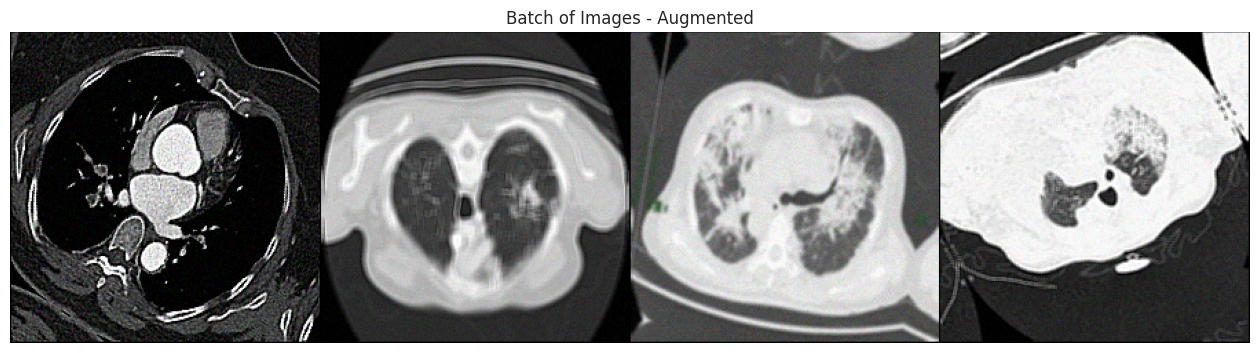

In [ ]:
plt.figure(figsize=(16, 16))
grid_img = torchvision.utils.make_grid(batch[0], 4, 1)
plt.axis('off')
plt.imshow(grid_img.permute(1, 2, 0))
plt.title('Batch of Images - Augmented')

In [ ]:
train_set, val_set = random_split(dataset, [train_set_size, val_set_size])

In [ ]:
class LightningModel(LightningModule):

    def __init__(self):

        super(LightningModel, self).__init__()

        self.resnet18 = models.resnet18(pretrained=True)
        self.resnet18.fc=nn.Sequential(nn.Linear(self.resnet18.fc.in_features,256),
                                       nn.ReLU(),
                                       nn.Linear(256,1))

        self.lr = 1e-4
        self.batch_size = 224
        self.numworker = 12

        self.criterion = nn.BCEWithLogitsLoss()
        self.acc = torchmetrics.Accuracy(task='binary')

        self.trainacc, self.valacc = [], []
        self.trainloss, self.valloss = [], []

        self.dataset = DataReader(dataset, aug)

        self.train_set, self.val_set = random_split(self.dataset, [train_set_size, val_set_size])


        self.training_step_loss_outputs = []
        self.training_step_acc_outputs = []

        self.validation_step_loss_outputs = []
        self.validation_step_acc_outputs = []


    def forward(self, x):

        x = self.resnet18(x)

        return x


    def configure_optimizers(self):
        opt = torch.optim.AdamW(params=self.parameters(), lr=self.lr)

        return opt


    def train_dataloader(self):
        train_loader = DataLoader(DataReader(train_set, aug),
                                  shuffle=True, batch_size=self.batch_size, num_workers=self.numworker)

        return train_loader


    def training_step(self, batch, batch_idx):
        image, label = batch
        pred = self(image)
        loss = self.criterion(pred.flatten(), label.float())
        acc = self.acc(pred.flatten(), label)

        self.training_step_loss_outputs.append(loss)
        self.training_step_acc_outputs.append(acc)

        return loss


    def on_train_epoch_end(self):
        loss = torch.stack(self.training_step_loss_outputs).mean().detach().cpu().numpy()
        acc  = torch.stack(self.training_step_acc_outputs).mean().detach().cpu().numpy()

        self.trainloss.append(loss)
        self.trainacc.append(acc)

        print(f'Epoch: {self.current_epoch} -- training loss: {loss:.4f} -- training acc: {acc:.2f}\n')


    def val_dataloader(self):
      val_loader = DataLoader(DataReader(train_set, aug),
                              shuffle=False, batch_size=self.batch_size, num_workers=self.numworker)

      return val_loader


    def validation_step(self, batch, batch_idx):
        image, label = batch
        pred = self(image) # or self.resnet18(image) or self.forward(image)
        loss = self.criterion(pred.flatten(), label.float())
        acc = self.acc(pred.flatten(), label)

        self.validation_step_loss_outputs.append(loss)
        self.validation_step_acc_outputs.append(acc)

        return loss


    def on_validation_epoch_end(self):
        loss = torch.stack(self.validation_step_loss_outputs).mean().detach().cpu().numpy()
        acc  = torch.stack(self.validation_step_acc_outputs).mean().detach().cpu().numpy()

        self.valloss.append(loss)
        self.valacc.append(acc)

        self.validation_step_loss_outputs.clear()
        self.validation_step_acc_outputs.clear()

        print(f'Epoch: {self.current_epoch} -- val loss:      {loss:.4f} -- val acc:      {acc:.2f}')


In [ ]:
model = LightningModel()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 124MB/s]


In [ ]:
seed_everything(0)

trainer = Trainer(max_epochs=20,
                  deterministic=True,
                  accelerator="auto",
                  precision='16-mixed',
                  enable_progress_bar = False,
                  num_sanity_val_steps=0,
                  #limit_train_batches=20,
                  #limit_val_batches=5
                  )

INFO:lightning_fabric.utilities.seed:Global seed set to 0
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params
------------------------------------------------
0 | resnet18  | ResNet            | 11.3 M
1 | criterion | BCEWithLogitsLoss | 0     
2 | acc       | BinaryAccuracy    | 0     
------------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.232    Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warnin

Epoch: 0 -- val loss:      0.6682755351066589 -- val acc:      0.5508231520652771
Epoch: 0 -- training loss: 0.6703798174858093 -- training acc: 0.5583440661430359

Epoch: 1 -- val loss:      0.6623058319091797 -- val acc:      0.6060703992843628
Epoch: 1 -- training loss: 0.6387378573417664 -- training acc: 0.6217088103294373

Epoch: 2 -- val loss:      0.6274163126945496 -- val acc:      0.6342905759811401
Epoch: 2 -- training loss: 0.615168571472168 -- training acc: 0.6483224034309387

Epoch: 3 -- val loss:      0.5526230931282043 -- val acc:      0.6969782710075378
Epoch: 3 -- training loss: 0.5918326377868652 -- training acc: 0.6731619834899902

Epoch: 4 -- val loss:      0.4935593605041504 -- val acc:      0.744758129119873
Epoch: 4 -- training loss: 0.5683223009109497 -- training acc: 0.693487286567688

Epoch: 5 -- val loss:      0.4691319465637207 -- val acc:      0.7851244807243347
Epoch: 5 -- training loss: 0.550894021987915 -- training acc: 0.7055224776268005

Epoch: 6 -- va

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
trainacc = model.trainacc
trainloss = model.trainloss

valacc = model.valacc
valloss = model.valloss

In [ ]:
trainer.validate(model)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch: 20 -- val loss:      0.3104737401008606 -- val acc:      0.8506274223327637


[{}]

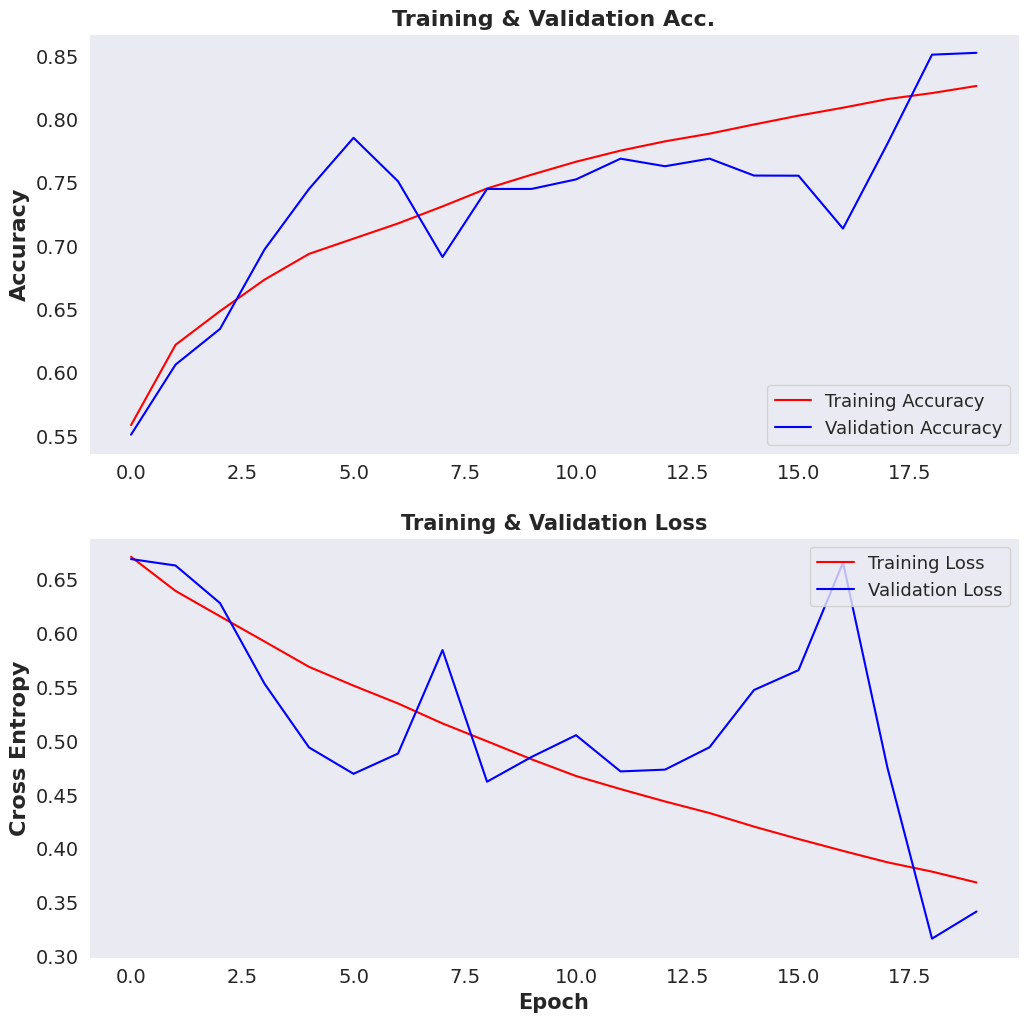

In [ ]:
plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(trainacc, label='Training Accuracy', color='r')
plt.plot(valacc[:-1], label='Validation Accuracy', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=13)
plt.ylabel('Accuracy', fontsize=16, weight='bold')
plt.title('Training & Validation Acc.', fontsize=16, weight='bold')


plt.subplot(2, 1, 2)
plt.plot(trainloss, label='Training Loss', color='r')
plt.plot(valloss[:-1], label='Validation Loss', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('Cross Entropy', fontsize=16, weight='bold')
plt.title('Training & Validation Loss', fontsize=15, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')

plt.show()

In [ ]:
# Classification Report